In [1]:
!nvidia-smi

Mon May 13 11:19:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
!pip install textblob 'keras-nlp' 'keras-preprocessing' 'gensim==4.2.0' np_utils swifter 'tensorflow-text==2.15'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 61.3 MB/s eta 0:00:00
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=f9ca6c6e905f6b38fcdabab287cafb3fafec8f15f47ebe5d4c09e3b46b21babd
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=1e5d9

In [4]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import pickle
from tensorflow.nn import leaky_relu

import re
import warnings
from sklearn.model_selection import train_test_split
from textblob import TextBlob

TRACE = False
embedding_dim = 300
epochs=100
batch_size = 250
corpus_size=25000
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config)
  tf.compat.v1.keras.backend.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
textblob_tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
%%writefile get_data.sh
if [ ! -f news.csv ]; then
  wget -O news.csv https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
fi

Writing get_data.sh


In [6]:
!bash get_data.sh

--2024-05-13 11:20:09--  https://www.dropbox.com/s/352x7xzivf60zgc/news.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/352x7xzivf60zgc/news.csv [following]
--2024-05-13 11:20:10--  https://www.dropbox.com/s/raw/352x7xzivf60zgc/news.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc50127badc3aa6f54ccfc92d1c.dl.dropboxusercontent.com/cd/0/inline/CS12paMcQC00Ow4v5fAu1QgnNWYEEaP7cppfTv5WrJQps5Fbxf6Zyp78bZVgE4NqRN1roT68bVBlCbOrvBJhD8pnYk0WgQJKSMXmUHMsKtUg6UKOVUoLFa6LbkoX0NU0O9zGh5jT2qlZPTEVYyWafhvZ/file# [following]
--2024-05-13 11:20:10--  https://ucc50127badc3aa6f54ccfc92d1c.dl.dropboxusercontent.com/cd/0/inline/CS12paMcQC00Ow4v5fAu1QgnNWYEEaP7cppfTv5WrJQps5Fbxf6Zyp78bZVgE4NqRN1roT68bVBlCbOrvBJhD8pnYk0WgQJKSMXmUHMsKt

In [7]:
path = './news.csv'
news_pre = pd.read_csv(path, header=0).sample(n=corpus_size).reset_index(drop=True)

In [8]:
def preprocess_text(text, should_join=True):
    # Use the tokenizer to tokenize into words, lowercase them, remove punctuation, and finally use gensim.utils.simple_preprocess(text)
    text = ' '.join(word.lower() for word in textblob_tokenizer(text))
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [9]:
import swifter
# Use swifter to apply the preprocessin and save that pandas series to a file
news = news_pre.title.swifter.apply(preprocess_text)
news.to_csv('news_processed.csv', index=False, header=False)

Pandas Apply:   0%|          | 0/25000 [00:00<?, ?it/s]

In [10]:

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = 'news_processed.csv'
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield preprocess_text(line, should_join=False)

from gensim.models import Word2Vec
word2vec_model = Word2Vec(MyCorpus(), vector_size=embedding_dim, min_count=3, workers=multiprocessing.cpu_count(), epochs=10)
# Get a word2vec model using gensim.models and passing the sentences using MyCorpus()

In [11]:
wv_model = word2vec_model.wv

In [13]:
weights = tf.constant(wv_model.vectors)  # Get the weights of the model (the embedding) and convert to tensor. Hint: Check word2vec_model.wv
vocab_size = len(wv_model.index_to_key)  # get vocab size from index_to_key in word2vec_model.wv

In [14]:
weights.shape

TensorShape([7279, 300])

In [15]:
news_preprocessed = pd.DataFrame()
news_preprocessed['label'] = news_pre.category.map({'Business': 0, 'Sports': 1, 'Sci/Tech': 2, 'World': 3})
news_preprocessed['title'] = news
news_preprocessed

,label,title
0,0,bbc set for major shake up claims newspaper
1,0,marsh averts cash crunch
2,1,jeter yankees look to take control ap
3,2,flying the sun to safety
4,0,stocks seen flat as nortel and oil weigh
...,...,...
24995,0,wal mart clarifies policy regarding unions ap
24996,2,viewpoint better russian planning would preven...
24997,1,no syracuse princeton
24998,1,usc oklahoma still auburn third in bcs


In [16]:
def get_maximum_review_length(df):
    maximum = 0
    for ix, row in df.iterrows():
        candidate = len(textblob_tokenizer(row.title))
        if candidate > maximum:
            maximum = candidate
    return maximum


maximum = get_maximum_review_length(news_preprocessed)   # Since 2 titles may have different number of words, we have to find the max length and fill with 0s if a title is shorter

In [17]:
X = np.zeros((len(news_preprocessed), maximum))   # Here we do what we said above
# Iterate through the news df and for every word, if it exists in the word2vec model, put into X for that review and that word the index of the embedding (check index_to_key)
# HINT: to iterate through a column of a pandas dataframe you do:

# for index, value in df.iterrows():
#      #do something
for row_ix, row in news_preprocessed.iterrows():
    for word_ix, word in enumerate(textblob_tokenizer(row.title)):
        if word in wv_model.key_to_index:
            X[row_ix, word_ix] = wv_model.key_to_index[word]
y = news_preprocessed.label

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)
# Convert y_train and y_test from an array of values between 0-3 to a one hot matrix tensor
y_train = tf.one_hot(y_train, depth=4)
y_test = tf.one_hot(y_test, depth=4)


In [19]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maximum, trainable=False, embeddings_initializer=Constant(weights)))  # Add an Embedding layer with weights being the rweights variable and trainable as False. The embedding dimension should be embedding_dim
model.add(Dense(100, activation='relu'))  # Add a couple of Dense Layers with RELU or leaky_relu activations. You may add Batch Norm if you want too
model.add(Dense(75, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(None, embedding_dim,)))  # Average out the words of the sentence. The expected out is (N, D) where N is number f samples in batch and D is embedding dimension
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Add final Dense layer

In [20]:
# Compile the model. Think what is the best loss to use
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 300)           2183700   
                                                                 
 dense (Dense)               (None, 18, 100)           30100     
                                                                 
 dense_1 (Dense)             (None, 18, 75)            7575      
                                                                 
 dense_2 (Dense)             (None, 18, 50)            3800      
                                                                 
 dense_3 (Dense)             (None, 18, 25)            1275      
                                                                 
 lambda (Lambda)             (None, 25)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                2

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[callback])
# Fit the model, use the callback above to do EarlyStopping

Epoch 1/100
80/80 [==============================] - 4s 7ms/step - loss: 1.2946 - accuracy: 0.3882 - val_loss: 1.1438 - val_accuracy: 0.4764
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 1.0644 - accuracy: 0.5337 - val_loss: 1.0039 - val_accuracy: 0.5880
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 0.9576 - accuracy: 0.6093 - val_loss: 0.9208 - val_accuracy: 0.6298
Epoch 4/100
80/80 [==============================] - 0s 4ms/step - loss: 0.8849 - accuracy: 0.6487 - val_loss: 0.8595 - val_accuracy: 0.6592
Epoch 5/100
80/80 [==============================] - 0s 4ms/step - loss: 0.8568 - accuracy: 0.6625 - val_loss: 0.8471 - val_accuracy: 0.6668
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 0.8376 - accuracy: 0.6732 - val_loss: 0.8377 - val_accuracy: 0.6714
Epoch 7/100
80/80 [==============================] - 0s 4ms/step - loss: 0.8236 - accuracy: 0.6799 - val_loss: 0.8136 - val_accuracy: 0.6832
Epoch 8/100
8

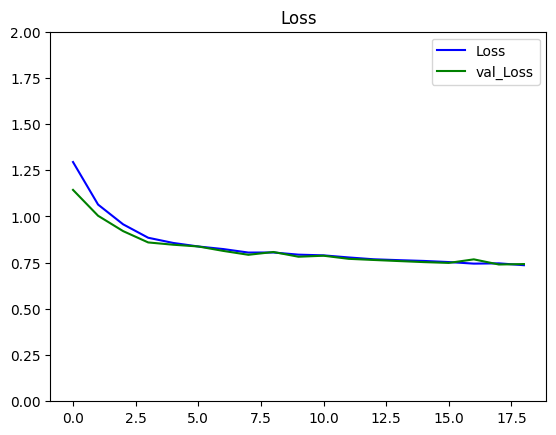

In [22]:
import matplotlib.pyplot as plt

# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=2.0)


In [23]:
# Test with the following two sentences:
# - 'supercomputer will put workers jobless soon'
# - 'patriots goes winning super bowl'

x_val = np.zeros((2, maximum))
for index, row in enumerate(['supercomputer will put workers jobless soon', 'patriots goes winning super bowl']):
    for word_ix, word in enumerate(textblob_tokenizer(row)):
        if word in wv_model.key_to_index:
            x_val[index, word_ix] = wv_model.key_to_index[word]
y_val = tf.one_hot([0,1], depth=4)

In [24]:
x_val

array([[1061.,   44.,  400.,  281.,  942., 1046.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [ 955.,  310.,  976., 1363., 1083.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])

In [25]:
x_val = tf.constant(x_val)

In [27]:
tf.math.argmax(model.predict(x_val), axis=1)

1/1 [==============================] - 0s 26ms/step


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>

In [28]:
model.evaluate(X_test, y_test)

157/157 [==============================] - 1s 3ms/step - loss: 0.7425 - accuracy: 0.7170


[0.7424740195274353, 0.7170000076293945]